# ModernBERT Training on KNN Datasets

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, roc_auc_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from checklist.pred_wrapper import PredictorWrapper
from checklist.test_types import MFT
from transformers import pipeline
import dataHandler as dh

In [2]:
from torch.nn import CrossEntropyLoss

# Custom Trainer class with density-weighted loss
class DensityWeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss function that incorporates density weights for each sample.
        """
        #print(f"Inputs keys: {inputs.keys()}")
        density_weights = inputs.pop("density_weight", None)
        labels = inputs.pop("labels", None)
        

        #print(f"Density weights found: {density_weights}")
        #print(f"Labels found: {labels}")

        # Forward pass with the remaining inputs (which should only be model inputs)
        outputs = model(**inputs)
        
        # Get logits
        logits = outputs.get('logits')
        
        # Check if we have both labels and logits to compute the loss
        if labels is not None and logits is not None:
            if density_weights is not None:
                # Compute cross entropy loss for each sample (no reduction)
                loss_fct = CrossEntropyLoss(reduction='none')
                
                # Ensure proper reshaping for loss function
                if logits.ndim > 2:
                    # For token classification or other tasks where logits have more than 2 dimensions
                    loss_per_sample = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
                else:
                    loss_per_sample = loss_fct(logits, labels)
                
                # Apply density weights
                density_weights = density_weights.to(loss_per_sample.device)
                weighted_loss = loss_per_sample * density_weights
                
                # Take the mean of weighted losses
                loss = weighted_loss.mean()
                
                # Store the loss in outputs for logging/saving
                outputs.loss = loss
                
                #print(f"Using density-weighted loss. Weights range: {density_weights.min():.3f} - {density_weights.max():.3f}")
                
                return (loss, outputs) if return_outputs else loss
            else:
                # Fallback to standard unweighted loss if weights are not provided
                print("WARNING: density_weight not found in inputs, using unweighted loss.")
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
                outputs.loss = loss
                return (loss, outputs) if return_outputs else loss
        else:
            # If labels or logits are missing, we can't compute loss.
            # This is normal during evaluation, so we return the model's outputs.
            if hasattr(outputs, 'loss') and outputs.loss is not None:
                return (outputs.loss, outputs) if return_outputs else outputs.loss
            else:
                # Return a dummy loss if no loss is available
                dummy_loss = torch.tensor(0.0, requires_grad=True).to(next(model.parameters()).device)
                return (dummy_loss, outputs) if return_outputs else dummy_loss

## Load and Process KNN Datasets

In [3]:
# Define paths to the KNN datasets
knn_datasets = {
    'k5': 'selected_knn_new/samples_knn_k5_percent100.csv',
    'k100': 'selected_knn_new/samples_knn_k100_percent100.csv',
    'k1000': 'selected_knn_new/samples_knn_k1000_percent100.csv',
    'k5_balanced': 'selected_knn_new/samples_knn_k5_percent100_balanced.csv',
    'k100_balanced': 'selected_knn_new/samples_knn_k100_percent100_balanced.csv',
    'k1000_balanced': 'selected_knn_new/samples_knn_k1000_percent100_balanced.csv',
    #'k5': 'selected_knn/samples_knn_k5
    #'k100': 'selected_knn/samples_knn_k100_percent10.csv',
    #'k1000': 'selected_knn/samples_knn_k1000_percent10.csv',
    #'k10000': 'selected_knn/samples_knn_k10000_percent10.csv',
    #'k5_balanced': 'selected_knn/samples_knn_k5_percent10_balanced.csv',
    #'k100_balanced': 'selected_knn/samples_knn_k100_percent10_balanced.csv',
    #'k1000_balanced': 'selected_knn/samples_knn_k1000_percent10_balanced.csv',
    #'k10000_balanced': 'selected_knn/samples_knn_k10000_percent10_balanced.csv',
    #'balanced_term': 'new_data/balanced_term_samples.csv',  # Added the balanced term dataset
}

# Function to prepare dataset for training with density weights
def prepare_dataset(file_path, test_size=0.2, random_state=42):
    df = pd.read_csv(file_path)
    
    print(f"Loading dataset from {file_path}")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Check if required columns exist
    if 'density' not in df.columns:
        raise ValueError(f"'density' column not found in {file_path}. Available columns: {df.columns.tolist()}")
    
    # Convert labels to binary
    df['label'] = df['label'].apply(lambda x: 1 if x == 'hate' else 0)
    
    # Check for missing values in density column
    if df['density'].isna().any():
        print(f"WARNING: Found {df['density'].isna().sum()} missing density values. Filling with median.")
        df['density'] = df['density'].fillna(df['density'].median())
    
    # Normalize density values to use as weights (min-max normalization to [0.1, 2.0] range)
    min_density = df['density'].min()
    max_density = df['density'].max()
    
    if min_density == max_density:
        print("WARNING: All density values are the same. Setting equal weights.")
        df['density_weight'] = 2.0
    else:
        df['density_weight'] = 0.1 + (df['density'] - min_density) / (max_density - min_density) * 1.9
    
    print(f"Density range: {min_density:.6f} - {max_density:.6f}")
    print(f"Weight range: {df['density_weight'].min():.3f} - {df['density_weight'].max():.3f}")
    print(f"Weight statistics:")
    print(f"  Mean: {df['density_weight'].mean():.3f}")
    print(f"  Std: {df['density_weight'].std():.3f}")
    print(f"  Median: {df['density_weight'].median():.3f}")
    
    # Split the data
    df_train = df.sample(frac=1-test_size, random_state=random_state)
    df_test = df.drop(df_train.index)
    
    # Verify density weights are numeric
    assert df_train['density_weight'].dtype in ['float64', 'float32', 'int64', 'int32'], "Density weights must be numeric"
    assert df_test['density_weight'].dtype in ['float64', 'float32', 'int64', 'int32'], "Density weights must be numeric"
    
    # Create datasets with density weights
    # Only keep columns that exist and remove the pandas index column if it exists
    columns_to_keep = ['text', 'label', 'density_weight']
    
    train_dataset = Dataset.from_pandas(df_train[columns_to_keep])
    test_dataset = Dataset.from_pandas(df_test[columns_to_keep])
    
    # Remove any auto-generated index columns
    for col in train_dataset.column_names:
        if col.startswith('__index_level_'):
            train_dataset = train_dataset.remove_columns([col])
            test_dataset = test_dataset.remove_columns([col])
    
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "test": test_dataset
    })
    
    # Verify the final dataset
    print(f"Final dataset features: {dataset_dict['train'].features}")
    sample = dataset_dict['train'][0]
    print(f"Sample density_weight: {sample['density_weight']} (type: {type(sample['density_weight'])})")
    
    return dataset_dict

processed_datasets = {}
for dataset_name, file_path in knn_datasets.items():
    processed_datasets[dataset_name] = prepare_dataset(file_path)
    print(f"Dataset {dataset_name} from {file_path}:")
    print(f"Train: {len(processed_datasets[dataset_name]['train'])} samples")
    print(f"Test: {len(processed_datasets[dataset_name]['test'])} samples")
    print(f"Label distribution in train: {processed_datasets[dataset_name]['train'].to_pandas()['label'].value_counts()}")
    print("---------------------------------------------------")

Loading dataset from selected_knn_new/samples_knn_k5_percent100.csv
Dataset shape: (250951, 4)
Columns: ['density', 'term', 'text', 'label']
Density range: 418.106050 - 9430.898000
Weight range: 0.100 - 2.000
Weight statistics:
  Mean: 0.137
  Std: 0.016
  Median: 0.135
Final dataset features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'density_weight': Value(dtype='float64', id=None)}
Sample density_weight: 0.14644574259810803 (type: <class 'float'>)
Dataset k5 from selected_knn_new/samples_knn_k5_percent100.csv:
Train: 200761 samples
Test: 50190 samples
Label distribution in train: label
0    148417
1     52344
Name: count, dtype: int64
---------------------------------------------------
Loading dataset from selected_knn_new/samples_knn_k100_percent100.csv
Dataset shape: (250951, 4)
Columns: ['density', 'term', 'text', 'label']
Density range: 388.394930 - 1084.871600
Weight range: 0.100 - 2.000
Weight statistics:
  Mean: 0.484
  Std: 0.113
  Medi

## Define Tokenization and Training Functions

In [4]:
# Load the ModernBERT tokenizer
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize(batch):
    tokenized = tokenizer(batch['text'], padding='max_length', truncation=True, max_length=140)
    
    # Add density weights and labels (handle both 'label' and 'labels' column names)
    tokenized['density_weight'] = batch['density_weight']
    if 'labels' in batch:
        tokenized['labels'] = batch['labels']
    elif 'label' in batch:
        tokenized['labels'] = batch['label']
    
    return tokenized

# Tokenize datasets
tokenized_datasets = {}
for dataset_name, dataset in processed_datasets.items():
    # Rename 'label' to 'labels' if it exists
    if "label" in dataset["train"].features.keys():
        dataset = dataset.rename_column("label", "labels")
        
    tokenized_dataset = dataset.map(tokenize, batched=True)
    tokenized_datasets[dataset_name] = tokenized_dataset
    
    print(f"Tokenized dataset {dataset_name}")
    print(f"Features: {tokenized_datasets[dataset_name]['test'].features.keys()}")
    
    # Check a sample to verify density weights are present
    sample = tokenized_datasets[dataset_name]['test'][0]
    if 'density_weight' in sample:
        print(f"Sample density weight: {sample['density_weight']} (type: {type(sample['density_weight'])})")
    else:
        print("WARNING: density_weight not found in sample!")
    print("---------------------------------------------------")

Map:   0%|          | 0/200761 [00:00<?, ? examples/s]

Map:   0%|          | 0/50190 [00:00<?, ? examples/s]

Tokenized dataset k5
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 2.0 (type: <class 'float'>)
---------------------------------------------------


Map:   0%|          | 0/200761 [00:00<?, ? examples/s]

Map:   0%|          | 0/50190 [00:00<?, ? examples/s]

Tokenized dataset k100
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 1.3746590736485116 (type: <class 'float'>)
---------------------------------------------------


Map:   0%|          | 0/200761 [00:00<?, ? examples/s]

Map:   0%|          | 0/50190 [00:00<?, ? examples/s]

Tokenized dataset k1000
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 1.761368014293212 (type: <class 'float'>)
---------------------------------------------------


Map:   0%|          | 0/152821 [00:00<?, ? examples/s]

Map:   0%|          | 0/38205 [00:00<?, ? examples/s]

Tokenized dataset k5_balanced
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 0.2382654925158264 (type: <class 'float'>)
---------------------------------------------------


Map:   0%|          | 0/152821 [00:00<?, ? examples/s]

Map:   0%|          | 0/38205 [00:00<?, ? examples/s]

Tokenized dataset k100_balanced
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 1.1481440785141928 (type: <class 'float'>)
---------------------------------------------------


Map:   0%|          | 0/152821 [00:00<?, ? examples/s]

Map:   0%|          | 0/38205 [00:00<?, ? examples/s]

Tokenized dataset k1000_balanced
Features: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density weight: 1.5474222208192916 (type: <class 'float'>)
---------------------------------------------------


In [5]:
# Debug: Check if density_weight survives tokenization
dataset_name = list(tokenized_datasets.keys())[0]
sample = tokenized_datasets[dataset_name]['train'][0]
print(f"Sample keys after tokenization: {sample.keys()}")
print(f"Sample density_weight: {sample.get('density_weight', 'MISSING')}")

# Check a small batch
small_batch = tokenized_datasets[dataset_name]['train'].select(range(3))
print(f"Small batch features: {small_batch.features}")

Sample keys after tokenization: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Sample density_weight: 0.14644574259810803
Small batch features: {'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'density_weight': Value(dtype='float64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


## Define Metric and Create Models

In [6]:
# Metric helper method
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    probs = torch.nn.functional.softmax(torch.tensor(eval_pred.predictions), dim=-1)

    try:
        aucroc = roc_auc_score(labels, probs[:, 1].numpy())
    except:
        aucroc = 0.5  # Default value if calculation fails
    
    return {
        "aucroc": aucroc
    }

# Prepare model labels
labels = ["no hate", "hate"]
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Function to create a model
def create_model():
    return AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=num_labels, label2id=label2id, id2label=id2label
    )

In [7]:
# Test cell to verify density weights are properly passed through the pipeline
print("Testing density weight pipeline...")

# Check if we have any processed datasets
if 'processed_datasets' in globals() and processed_datasets:
    dataset_name = list(processed_datasets.keys())[0]
    print(f"Testing with dataset: {dataset_name}")
    
    # Check raw dataset
    raw_sample = processed_datasets[dataset_name]['train'][0]
    print(f"Raw dataset sample keys: {raw_sample.keys()}")
    if 'density_weight' in raw_sample:
        print(f"Raw density weight: {raw_sample['density_weight']} (type: {type(raw_sample['density_weight'])})")
    
    # Check tokenized dataset
    if 'tokenized_datasets' in globals() and dataset_name in tokenized_datasets:
        tokenized_sample = tokenized_datasets[dataset_name]['train'][0]
        print(f"Tokenized dataset sample keys: {tokenized_sample.keys()}")
        if 'density_weight' in tokenized_sample:
            print(f"Tokenized density weight: {tokenized_sample['density_weight']} (type: {type(tokenized_sample['density_weight'])})")
        
        # Test a small batch
        small_batch = tokenized_datasets[dataset_name]['train'].select(range(3))
        print(f"Small batch features: {small_batch.features}")
        
        # Convert to DataLoader format to see what the trainer will receive
        from torch.utils.data import DataLoader
        from transformers import default_data_collator
        
        dataloader = DataLoader(small_batch, batch_size=2, collate_fn=default_data_collator)
        batch = next(iter(dataloader))
        print(f"Batch keys: {batch.keys()}")
        if 'density_weight' in batch:
            print(f"Batch density weights: {batch['density_weight']}")
        else:
            print("WARNING: density_weight not found in batch!")
else:
    print("No processed datasets found. Run the dataset preparation cells first.")

print("Pipeline test complete.\n" + "="*50)

Testing density weight pipeline...
Testing with dataset: k5
Raw dataset sample keys: dict_keys(['text', 'label', 'density_weight'])
Raw density weight: 0.14644574259810803 (type: <class 'float'>)
Tokenized dataset sample keys: dict_keys(['text', 'labels', 'density_weight', 'input_ids', 'attention_mask'])
Tokenized density weight: 0.14644574259810803 (type: <class 'float'>)
Small batch features: {'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'density_weight': Value(dtype='float64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Batch keys: dict_keys(['labels', 'density_weight', 'input_ids', 'attention_mask'])
Batch density weights: tensor([0.1464, 0.1393])
Pipeline test complete.


## Training Loop

Now we'll train a model for each dataset.

In [ ]:
from transformers import EarlyStoppingCallback
from torch.nn import CrossEntropyLoss
import torch
from transformers import DataCollatorWithPadding
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

@dataclass
class DataCollatorWithDensityWeights(DataCollatorWithPadding):
    """
    Data collator that preserves density_weight field along with standard tokenizer outputs.
    """
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        
        print(features[0].keys())
        # Extract density weights
        density_weights = [feature.pop('density_weight', 12.0) for feature in features]
        
        # Call the parent collator for standard processing
        batch = super().__call__(features)
        
        # Add density weights back to the batch
        batch['density_weight'] = torch.tensor(density_weights, dtype=torch.float32)
        
        return batch

# Train a model for each dataset
trained_models = {}
for dataset_name, tokenized_dataset in tokenized_datasets.items():
    print(f"\nTraining model for dataset {dataset_name}...")
    
    model = create_model()
    model.to(device)
    
    # Define training arguments
    output_dir = f"models_knn_test/toxigen-{dataset_name}-classifier"
    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=32,        
        per_device_eval_batch_size=32,          
        learning_rate=2e-5,
        num_train_epochs=2,                     
        warmup_ratio=0.1,                       
        weight_decay=0.01,                      
        bf16=torch.cuda.is_available(),         
        fp16=not torch.cuda.is_available() and hasattr(torch, 'has_mps'),  
        optim="adamw_torch_fused" if torch.cuda.is_available() else "adamw_torch", 
        logging_strategy="steps",
        logging_steps=50,                       
        eval_strategy="steps",            
        eval_steps=2000,                        
        save_strategy="steps",                  
        save_steps=2000,                         
        save_total_limit=3,                     
        load_best_model_at_end=True,
        metric_for_best_model="aucroc",
        greater_is_better=True,                 
        gradient_accumulation_steps=1,          
        report_to="tensorboard",                
        lr_scheduler_type="cosine",            
        seed=42,
        remove_unused_columns=False                               
    )
    
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=4,
        early_stopping_threshold=0.001
    )
    
    # Create custom data collator
    data_collatorX = DataCollatorWithDensityWeights(
        tokenizer=tokenizer,
        padding=True,
        return_tensors="pt"
    )
    
    # Create a DensityWeightedTrainer instance with custom data collator
    trainer = DensityWeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback],
        #data_collator=data_collatorX
    )
    
    # Train the model
    trainer.train()
    
    model_path = f"models_knn_test/ModernBERT-{dataset_name}-final"
    tokenizer_path = f"models_knn_test/ModernBERT-{dataset_name}-tokenizer"
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)
    
    #print(f"Model for {dataset_name} saved to {model_path}")
    #print(f"Tokenizer for {dataset_name} saved to {tokenizer_path}")
    
    trained_models[dataset_name] = {
        "model_path": model_path,
        "tokenizer_path": tokenizer_path
    }

Using device: cuda

Training model for dataset k5...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.026000,0.028053,0.969666
4000,0.025500,0.023590,0.977247
6000,0.022900,0.021955,0.979520
8000,0.012000,0.024158,0.979638
10000,0.011400,0.023195,0.981050
12000,0.009400,0.022713,0.981406



Training model for dataset k100...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.102200,0.092149,0.971624
4000,0.090000,0.084994,0.975758
6000,0.082700,0.079715,0.978969
8000,0.052500,0.088062,0.980300
10000,0.039300,0.088064,0.980942
12000,0.048700,0.086380,0.981279



Training model for dataset k1000...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.125900,0.126369,0.969655
4000,0.120300,0.105784,0.975940
6000,0.094800,0.101926,0.978955
8000,0.054400,0.119080,0.979416
10000,0.054900,0.111015,0.980763
12000,0.040200,0.111227,0.981080



Training model for dataset k5_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.028900,0.027200,0.973117
4000,0.027300,0.025216,0.978142
6000,0.013700,0.025258,0.979915
8000,0.012400,0.025146,0.980937



Training model for dataset k100_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.102400,0.104610,0.969867
4000,0.086700,0.091153,0.976940
6000,0.057700,0.102176,0.979159
8000,0.053300,0.098942,0.980358



Training model for dataset k1000_balanced...


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Aucroc
2000,0.137800,0.126915,0.972198
4000,0.111400,0.114117,0.977972
6000,0.064500,0.125596,0.979971
8000,0.057600,0.123602,0.980833


In [9]:
tokenized_dataset["train"].features

{'text': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 'density_weight': Value(dtype='float64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

## Create Evaluation Pipeline

In [10]:
# Define the HuggingFace pipeline wrapper for CheckList
class HuggingFacePipelineWrapper(PredictorWrapper):
    def __init__(self, pipeline_classifier):
        self.pipeline = pipeline_classifier
        
    def __call__(self, texts):
        predictions = []
        confidences = []
        
        for text in texts:
            prediction = self.pipeline(text)
            prediction = prediction[0]  
            
            label = prediction['label']
            score = prediction['score']
                
            predictions.append(label)
            confidences.append(score)
            
        return predictions, confidences

## Evaluate MFT


In [11]:
import os

# Find all model directories in models_knn folder
trained_models = {}
model_dirs = [d for d in os.listdir('models_knn_test') if os.path.isdir(os.path.join('models_knn_test', d))]

for dir_name in model_dirs:
    if dir_name.startswith('ModernBERT-') and dir_name.endswith('-final'):
        dataset_name = dir_name.replace('ModernBERT-', '').replace('-final', '')
        
        tokenizer_path = f"models_knn_test/ModernBERT-{dataset_name}-tokenizer"
        if os.path.isdir(tokenizer_path):
            trained_models[dataset_name] = {
                "model_path": f"models_knn_test/{dir_name}",
                "tokenizer_path": tokenizer_path
            }
            print(f"Found model and tokenizer for dataset: {dataset_name}")

print(f"Total models found: {len(trained_models)}")

Found model and tokenizer for dataset: k100
Found model and tokenizer for dataset: k1000
Found model and tokenizer for dataset: k1000_balanced
Found model and tokenizer for dataset: k100_balanced
Found model and tokenizer for dataset: k5
Found model and tokenizer for dataset: k5_balanced
Total models found: 6


In [12]:
trained_models

{'k100': {'model_path': 'models_knn_test/ModernBERT-k100-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k100-tokenizer'},
 'k1000': {'model_path': 'models_knn_test/ModernBERT-k1000-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k1000-tokenizer'},
 'k1000_balanced': {'model_path': 'models_knn_test/ModernBERT-k1000_balanced-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k1000_balanced-tokenizer'},
 'k100_balanced': {'model_path': 'models_knn_test/ModernBERT-k100_balanced-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k100_balanced-tokenizer'},
 'k5': {'model_path': 'models_knn_test/ModernBERT-k5-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k5-tokenizer'},
 'k5_balanced': {'model_path': 'models_knn_test/ModernBERT-k5_balanced-final',
  'tokenizer_path': 'models_knn_test/ModernBERT-k5_balanced-tokenizer'}}

In [13]:
# Get the test data
test_dict = dh.getAnnotadedRussTest()
print(f"Loaded test data with {len(test_dict['text'])} samples")

# Function to create and evaluate a pipeline
def evaluate_model(model_info, test_dict):
    print(f"\nEvaluating model from {model_info['model_path']}...")
    
    classifier = pipeline(
        task="text-classification", 
        tokenizer=AutoTokenizer.from_pretrained(model_info['tokenizer_path']),
        model=AutoModelForSequenceClassification.from_pretrained(model_info['model_path']),
        device=0 if torch.cuda.is_available() else -1
    )
    
    wrapped_classifier = HuggingFacePipelineWrapper(classifier)
    
    hate_test = MFT(data=test_dict['text'], labels=test_dict['label'], name="Basic Hate Test")
    result = hate_test.run(wrapped_classifier, overwrite=True)
    hate_test.summary()

evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    evaluation_results[dataset_name] = evaluate_model(model_info, test_dict)

Loaded test data with 996 samples

Evaluating model from models_knn_test/ModernBERT-k100-final...


Device set to use cuda:0


Predicting 996 examples


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Test cases:      996
Fails (rate):    320 (32.1%)

Example fails:
hate   go ahead - you are just going to destroy every relationship russia has and make enemies of all your neighbors. 
----
hate  i want them to make the up taylor's butt missile.
----
hate  ooh a bad ass you jealous of jordan?
----

Evaluating model from models_knn_test/ModernBERT-k1000-final...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    312 (31.3%)

Example fails:
hate    sending your maga-mob to kill congress, qualifies as an "act of war" - correct?
----
hate    he is so evil i believe god sent riley to punish the country. when you read in the bible 1 kings 15 you will see how history repeats. riley came to divide the country the families and friends. he and quinn are the same.
----
hate bullshit... total lies... ukraine does not do shit for america it is not in our interest to be bothered with ukraine! there's not even an actual war going on in ukraine youtube would not be holding concerts &amp; political figures would not be there for photo ops w/ jordan! bs lies
----

Evaluating model from models_knn_test/ModernBERT-k1000_balanced-final...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    316 (31.7%)

Example fails:
hate    that comparison just proves how dog shit cod mp has been the last 3+ years. saying vanguard is better than cold war means nothing lol
----
hate  can you send yourselves stimulus checks? ask dakota for a refund. how about the millions of illegals we’re fitting the bill for? what are you charging on our dime? this country is a mess because of you and your party. 
----
hate   oh so you're a jamie
puppet too? 😆 🤣 😂  
you really are a loser
----

Evaluating model from models_knn_test/ModernBERT-k100_balanced-final...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    315 (31.6%)

Example fails:
hate       wtf why is this all turning into a fukn pove fest wirh all the i luhhh yous. smh we at war with cake takes people
----
hate      you proved your official troll status by trolling all freaking weekend instead of watching (american) football. you are as american as vladimir skyler, j.e.b.
----
hate              no one cares for such russian bullshit, at this point russia needs be defeated both militarily and economically so that the russian people can rid ghemselves of the reese terrorist regime. how can russia keep this man in power who is killing his own people due to his failure.
----

Evaluating model from models_knn_test/ModernBERT-k5-final...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    309 (31.0%)

Example fails:
hate they should have left her law breaking america hatin ass in russia #brittanygriner
----
hate  since when is it okay for americans to support russia over america??? wtf
----
hate no cause you guys really found a way to make it about your stupid wwe vs. aew war. 

are y’all so annoyed ?
----

Evaluating model from models_knn_test/ModernBERT-k5_balanced-final...


Device set to use cuda:0


Predicting 996 examples
Test cases:      996
Fails (rate):    328 (32.9%)

Example fails:
hate  holy shit, your people are bad at this. are they geriatric interns you got off your facebook page? or is turkey just not as good as russia at this atuff?
----
hate i'm convinced russians have zero spacial awareness 😂😂 dude fired an rpg and hundreds of rounds from his foxhole and you still see the russian dude looking the opposite way 😂😂 and russia thinks they can invade the us, bro you wouldn't last 23 seconds in the appalachia 😂😂😂
----
no hate jordy petes: "russia is fighting a war against degeneracy! and we need to join them and create a right-wing international to defeat the globohomo octopus!"
----


## Evaluation Confusion Matrix

In [14]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_model_direct(model_info, test_dict):
    print(f"\nDirectly evaluating model from {model_info['model_path']}...")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_info['tokenizer_path'])
        model = AutoModelForSequenceClassification.from_pretrained(model_info['model_path'])
        model.to(device)
        
        true_labels = [1 if label == 'hate' else 0 for label in test_dict['label']]
        
        texts = test_dict['text']
        predicted_labels = []
        predicted_probs = []
        batch_size = 32
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=140)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                
                probs = torch.nn.functional.softmax(logits, dim=1)
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                probs_hate = probs[:, 1].cpu().numpy()  
                
                predicted_labels.extend(preds)
                predicted_probs.extend(probs_hate)
        
        # Calculate metrics
        acc = accuracy_score(true_labels, predicted_labels)
        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, predicted_labels, average='binary', pos_label=1
        )
        
        # Calculate AUC-ROC
        try:
            aucroc = roc_auc_score(true_labels, predicted_probs)
        except:
            aucroc = 0.5
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
        else:
            TN, FP, FN, TP = 0, 0, 0, 0
        
        results = {
            "accuracy": acc,
            "balanced_accuracy": balanced_acc,
            "precision": precision,
            "recall": recall,
            "aucroc": aucroc,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "predictions": predicted_labels,
            "probabilities": predicted_probs
        }
        
        print("Evaluation results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"Precision (hate): {precision:.4f}")
        print(f"Recall (hate): {recall:.4f}")
        print(f"AUC-ROC: {aucroc:.4f}")
        print(f"Confusion Matrix: [TP={TP}, FP={FP}, FN={FN}, TN={TN}]")
        
        return {
            "results": results,
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }
        
    except Exception as e:
        print(f"Error evaluating model: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            "results": None,
            "error": str(e),
            "model_name": model_info.get('model_path', '').split('/')[-1]
        }

In [15]:
# Run the direct evaluation on all models
direct_evaluation_results = {}
for dataset_name, model_info in trained_models.items():
    print(f"\nEvaluating model for {dataset_name}...")
    direct_evaluation_results[dataset_name] = evaluate_model_direct(model_info, test_dict)


Evaluating model for k100...

Directly evaluating model from models_knn_test/ModernBERT-k100-final...
Evaluation results:
Accuracy: 0.6787
Balanced Accuracy: 0.7634
Precision (hate): 0.3832
Recall (hate): 0.9078
AUC-ROC: 0.8453
Confusion Matrix: [TP=187, FP=301, FN=19, TN=489]

Evaluating model for k1000...

Directly evaluating model from models_knn_test/ModernBERT-k1000-final...
Evaluation results:
Accuracy: 0.6867
Balanced Accuracy: 0.7613
Precision (hate): 0.3877
Recall (hate): 0.8883
AUC-ROC: 0.8478
Confusion Matrix: [TP=183, FP=289, FN=23, TN=501]

Evaluating model for k1000_balanced...

Directly evaluating model from models_knn_test/ModernBERT-k1000_balanced-final...
Evaluation results:
Accuracy: 0.6827
Balanced Accuracy: 0.7659
Precision (hate): 0.3864
Recall (hate): 0.9078
AUC-ROC: 0.8494
Confusion Matrix: [TP=187, FP=297, FN=19, TN=493]

Evaluating model for k100_balanced...

Directly evaluating model from models_knn_test/ModernBERT-k100_balanced-final...
Evaluation results:


In [16]:
model_accuracies = {}
for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        accuracy = eval_result['results'].get('accuracy', 0)
        model_accuracies[dataset_name] = accuracy
        print(f"Model trained on {dataset_name} - Accuracy: {accuracy:.4f}")
    else:
        print(f"Model trained on {dataset_name} - Evaluation failed")

# Determine the best model using balanced accuracy
if model_accuracies:
    # Use balanced accuracy instead of regular accuracy
    balanced_accuracies = {}
    for dataset_name, eval_result in direct_evaluation_results.items():
        if eval_result.get('results') is not None:
            balanced_accuracy = eval_result['results'].get('balanced_accuracy', 0)
            balanced_accuracies[dataset_name] = balanced_accuracy
            print(f"Model trained on {dataset_name} - Balanced Accuracy: {balanced_accuracy:.4f}")
    
    best_model = max(balanced_accuracies.items(), key=lambda x: x[1])
    print(f"\nBest model by balanced accuracy: {best_model[0]} with score {best_model[1]:.4f}")
    
    # Also find best model by AUCROC
    aucroc_scores = {}
    for dataset_name, eval_result in direct_evaluation_results.items():
        if eval_result.get('results') is not None:
            aucroc = eval_result['results'].get('aucroc', 0)
            aucroc_scores[dataset_name] = aucroc
            print(f"Model trained on {dataset_name} - AUC-ROC: {aucroc:.4f}")
    
    best_model_aucroc = max(aucroc_scores.items(), key=lambda x: x[1])
    print(f"\nBest model by AUC-ROC: {best_model_aucroc[0]} with score {best_model_aucroc[1]:.4f}")
    
# Save the best model information to a file
if 'best_model' in locals() and best_model[1] > 0:
    with open('models_knn_test/best_model_info_direct.txt', 'w') as f:
        f.write(f"Best model: {best_model[0]}\n")
        f.write(f"Accuracy: {best_model[1]:.4f}\n")
        f.write(f"Model path: {trained_models[best_model[0]]['model_path']}\n")
        f.write(f"Tokenizer path: {trained_models[best_model[0]]['tokenizer_path']}\n")
    
    print(f"\nBest model information saved to models_knn_test/best_model_info_direct.txt")

Model trained on k100 - Accuracy: 0.6787
Model trained on k1000 - Accuracy: 0.6867
Model trained on k1000_balanced - Accuracy: 0.6827
Model trained on k100_balanced - Accuracy: 0.6837
Model trained on k5 - Accuracy: 0.6898
Model trained on k5_balanced - Accuracy: 0.6707
Model trained on k100 - Balanced Accuracy: 0.7634
Model trained on k1000 - Balanced Accuracy: 0.7613
Model trained on k1000_balanced - Balanced Accuracy: 0.7659
Model trained on k100_balanced - Balanced Accuracy: 0.7701
Model trained on k5 - Balanced Accuracy: 0.7668
Model trained on k5_balanced - Balanced Accuracy: 0.7691

Best model by balanced accuracy: k100_balanced with score 0.7701
Model trained on k100 - AUC-ROC: 0.8453
Model trained on k1000 - AUC-ROC: 0.8478
Model trained on k1000_balanced - AUC-ROC: 0.8494
Model trained on k100_balanced - AUC-ROC: 0.8435
Model trained on k5 - AUC-ROC: 0.8445
Model trained on k5_balanced - AUC-ROC: 0.8474

Best model by AUC-ROC: k1000_balanced with score 0.8494

Best model info

## Visualize Direct Evaluation Results

Let's create visualizations for the direct evaluation results.

In [17]:
# Create a dataframe with the updated evaluation metrics
metrics_df_direct = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Balanced_Accuracy': [],
    'Precision': [],
    'Recall': [],
    'AUC_ROC': []
})

for dataset_name, eval_result in direct_evaluation_results.items():
    if eval_result.get('results') is not None:
        results = eval_result['results']
        metrics_df_direct = pd.concat([metrics_df_direct, pd.DataFrame({
            'Model': [dataset_name],
            'Accuracy': [results.get('accuracy', 0)],
            'Balanced_Accuracy': [results.get('balanced_accuracy', 0)],
            'Precision': [results.get('precision', 0)],
            'Recall': [results.get('recall', 0)],
            'AUC_ROC': [results.get('aucroc', 0)]
        })])

metrics_df_direct.reset_index(drop=True, inplace=True)
print(metrics_df_direct)

            Model  Accuracy  Balanced_Accuracy  Precision    Recall   AUC_ROC
0            k100  0.678715           0.763377   0.383197  0.907767  0.845299
1           k1000  0.686747           0.761263   0.387712  0.888350  0.847800
2  k1000_balanced  0.682731           0.765909   0.386364  0.907767  0.849379
3   k100_balanced  0.683735           0.770130   0.388090  0.917476  0.843477
4              k5  0.689759           0.766751   0.391121  0.898058  0.844470
5     k5_balanced  0.670683           0.769080   0.379921  0.936893  0.847419


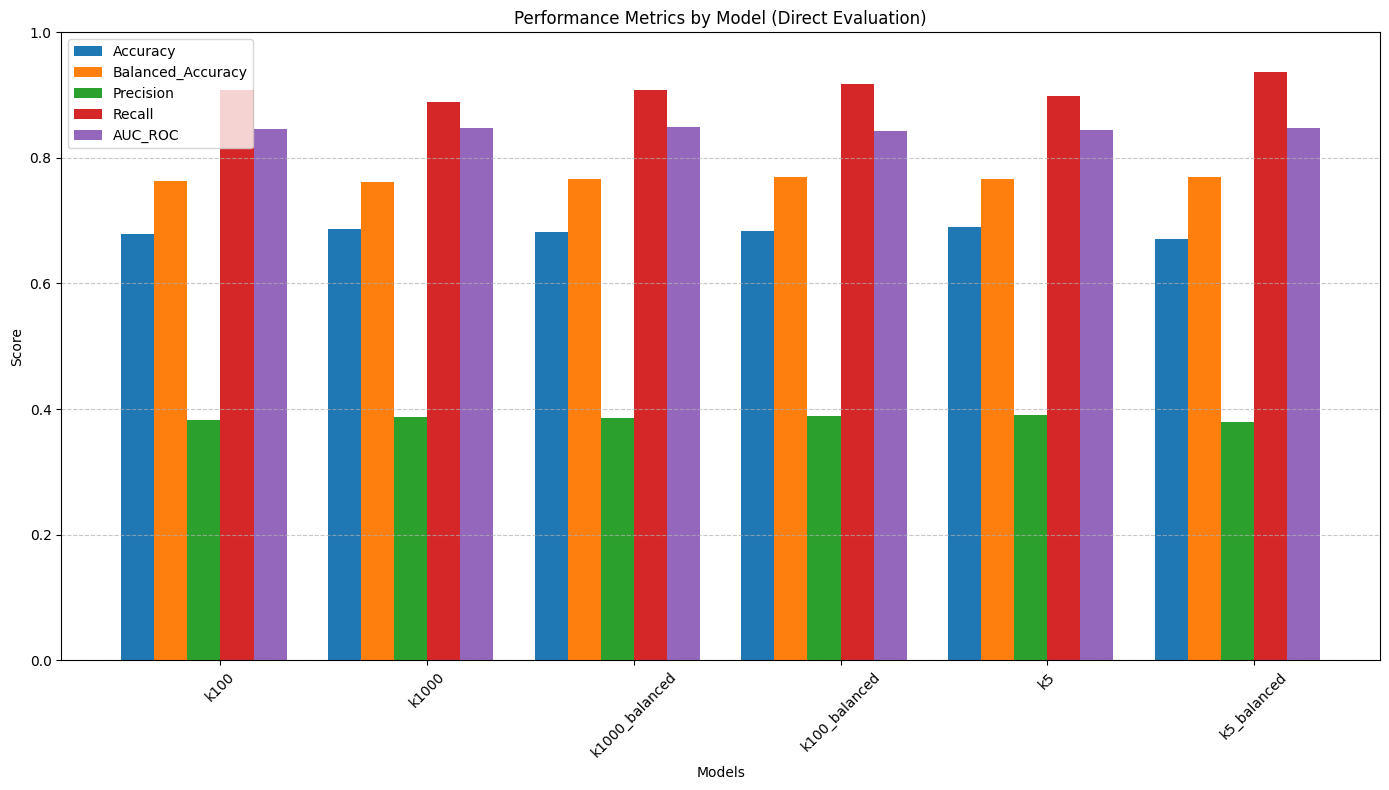

In [18]:
import matplotlib.pyplot as plt

if not metrics_df_direct.empty:
    plt.figure(figsize=(14, 8))
    
    metric_columns = ['Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'AUC_ROC']
    x = np.arange(len(metrics_df_direct['Model']))
    width = 0.16  # Narrower bars to fit all metrics
    
    for i, metric in enumerate(metric_columns):
        plt.bar(x + i*width - 0.32, metrics_df_direct[metric], width, label=metric)
    
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.title('Performance Metrics by Model (Direct Evaluation)')
    plt.xticks(x + width/2, metrics_df_direct['Model'], rotation=45)
    plt.ylim(0, 1.0)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.savefig('models_knn_test/model_comparison_metrics_direct.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for plotting.")

In [19]:
import seaborn as sns

# Analyze the term distribution in the balanced_term dataset
if 'balanced_term' in knn_datasets:
    try:
        balanced_df = pd.read_csv(knn_datasets['balanced_term'])
        
        if 'term' in balanced_df.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
            
            # Plot term distribution
            term_counts = balanced_df['term'].value_counts()
            sns.barplot(x=term_counts.index, y=term_counts.values, ax=ax1)
            ax1.set_title('Term Distribution in Balanced Term Dataset')
            ax1.set_xlabel('Term')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=45)
            
            # Plot label distribution within each term
            term_label = balanced_df.groupby(['term', 'label']).size().unstack(fill_value=0)
            term_label.plot(kind='bar', stacked=True, ax=ax2)
            ax2.set_title('Label Distribution by Term')
            ax2.set_xlabel('Term')
            ax2.set_ylabel('Count')
            ax2.tick_params(axis='x', rotation=45)
            ax2.legend(['No Hate', 'Hate'])
            
            plt.tight_layout()
            plt.savefig('models_knn/balanced_term_distribution.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print statistics
            print("\nTerm Distribution in Balanced Term Dataset:")
            for term, count in term_counts.items():
                print(f"  {term}: {count} samples ({count/len(balanced_df)*100:.1f}%)")
            
            # Print label distribution by term
            print("\nLabel Distribution by Term:")
            term_label_pct = term_label.div(term_label.sum(axis=1), axis=0)
            for term in term_label_pct.index:
                hate_pct = term_label_pct.loc[term, 1] * 100 if 1 in term_label_pct.columns else 0
                print(f"  {term}: {hate_pct:.1f}% hate content")
                
            # Print overall label distribution
            print("\nOverall Label Distribution:")
            label_counts = balanced_df['label'].value_counts()
            for label, count in label_counts.items():
                label_name = 'Hate' if label == 1 else 'No Hate'
                print(f"  {label_name}: {count} samples ({count/len(balanced_df)*100:.1f}%)")
        else:
            print("The 'term' column is not present in the balanced_term dataset.")
    except Exception as e:
        print(f"Error analyzing balanced_term dataset: {str(e)}")
else:
    print("The balanced_term dataset is not included in the knn_datasets dictionary.")

The balanced_term dataset is not included in the knn_datasets dictionary.


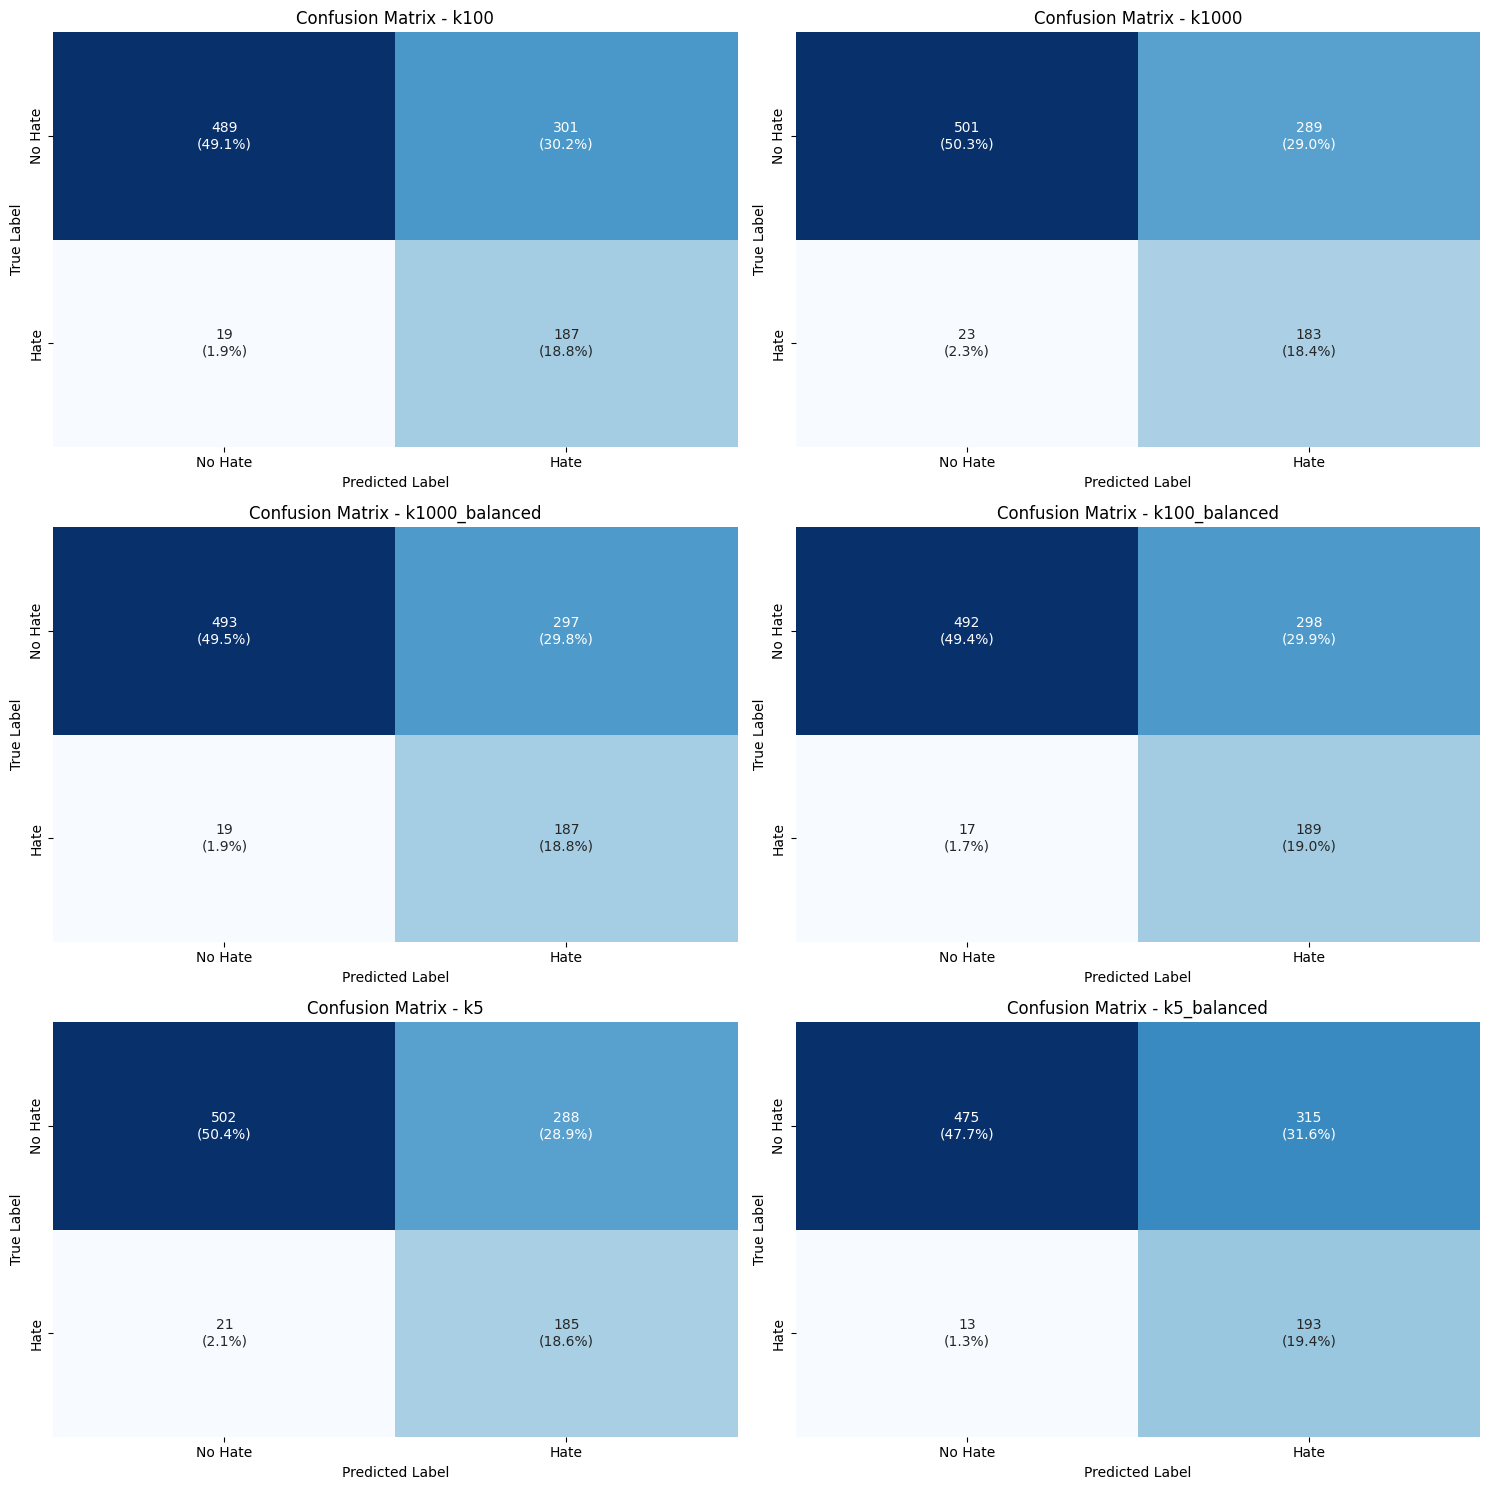

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create confusion matrices for each model using direct evaluation
if not metrics_df_direct.empty:

    num_models = len(metrics_df_direct)
    if num_models <= 2:
        nrows, ncols = 1, num_models
    else:
        nrows = (num_models + 1) // 2  
        ncols = 2
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))
    
    # Handle the case of a single subplot
    if num_models == 1:
        axes = np.array([axes])
    elif nrows == 1 and ncols > 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, (dataset_name, eval_result) in enumerate(direct_evaluation_results.items()):
        if eval_result.get('results') is None:
            continue
        
        results = eval_result['results']
        
        # Extract confusion matrix values
        TP = results.get('TP', 0)
        FP = results.get('FP', 0)
        FN = results.get('FN', 0)
        TN = results.get('TN', 0)
        
        # Create confusion matrix
        cm = np.array([[TN, FP], [FN, TP]])
        
        # Calculate total samples for percentage calculation
        total = TN + FP + FN + TP
        
        # Create a string representation with count and percentage
        cm_text = np.array([[f"{TN}\n({TN/total:.1%})", f"{FP}\n({FP/total:.1%})"], 
                           [f"{FN}\n({FN/total:.1%})", f"{TP}\n({TP/total:.1%})"]])
        
        # Plot confusion matrix with custom annotations
        sns.heatmap(cm, annot=cm_text, fmt="", cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {dataset_name}')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['No Hate', 'Hate'])
        axes[i].set_yticklabels(['No Hate', 'Hate'])
    
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('models_knn_test/model_confusion_matrices_direct_with_percent.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for confusion matrices.")

In [21]:
# Compare balanced_term model performance with others
if 'balanced_term' in direct_evaluation_results and direct_evaluation_results['balanced_term'].get('results') is not None:
    bt_results = direct_evaluation_results['balanced_term']['results']
    
    # Create a comparison dataframe
    comparison_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'aucroc']
    comparison_df = pd.DataFrame(columns=['Metric', 'balanced_term', 'best_other_model', 'best_other_value', 'improvement'])
    
    # Find best model excluding balanced_term for each metric
    for metric in comparison_metrics:
        best_other_value = 0
        best_other_model = ''
        
        for model_name, eval_result in direct_evaluation_results.items():
            if model_name != 'balanced_term' and eval_result.get('results') is not None:
                value = eval_result['results'].get(metric, 0)
                if value > best_other_value:
                    best_other_value = value
                    best_other_model = model_name
        
        bt_value = bt_results.get(metric, 0)
        improvement = ((bt_value - best_other_value) / best_other_value) * 100 if best_other_value > 0 else 0
        
        comparison_df = pd.concat([comparison_df, pd.DataFrame({
            'Metric': [metric.capitalize()],
            'balanced_term': [bt_value],
            'best_other_model': [best_other_model],
            'best_other_value': [best_other_value],
            'improvement': [improvement]
        })])
    
    # Print comparison table
    comparison_df.reset_index(drop=True, inplace=True)
    print("Performance comparison between balanced_term model and best other models:")
    print(comparison_df)
    
    # Create bar chart comparing balanced_term with best models
    plt.figure(figsize=(12, 8))
    
    x = np.arange(len(comparison_metrics))
    width = 0.35
    
    plt.bar(x - width/2, comparison_df['balanced_term'], width, label='balanced_term')
    plt.bar(x + width/2, comparison_df['best_other_value'], width, label='Best Other Model')
    
    plt.xlabel('Metric')
    plt.ylabel('Score')
    plt.title('Balanced Term Model vs Best Other Models')
    plt.xticks(x, [m.capitalize() for m in comparison_metrics])
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add improvement percentage text above the bars
    for i, improvement in enumerate(comparison_df['improvement']):
        bt_value = comparison_df['balanced_term'].iloc[i]
        best_other = comparison_df['best_other_value'].iloc[i]
        
        if improvement > 0:
            color = 'green'
            label = f'+{improvement:.1f}%'
        else:
            color = 'red'
            label = f'{improvement:.1f}%'
        
        plt.text(i, max(bt_value, best_other) + 0.02, label, ha='center', va='bottom', color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('models_knn_test/balanced_term_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also add this to the summary file
    with open('models_knn/balanced_term_comparison.txt', 'w') as f:
        f.write("Performance comparison between balanced_term model and best other models:\n")
        f.write(comparison_df.to_string(index=False))
        f.write("\n\nThis analysis shows the impact of using the balanced term approach compared to the best performing models from other approaches.\n")
        
        # Add a summary assessment
        better_count = sum(1 for imp in comparison_df['improvement'] if imp > 0)
        if better_count >= 3:
            f.write("\nOverall, the balanced term approach shows significant improvement across multiple metrics, indicating that proper term balancing leads to better performance on the Russian test set.\n")
        elif better_count >= 1:
            f.write("\nThe balanced term approach shows some improvement on certain metrics, suggesting that term balancing can be beneficial but may need further refinement.\n")
        else:
            f.write("\nThe balanced term approach did not outperform existing models on the selected metrics. Further investigation may be needed to understand why and improve the approach.\n")
else:
    print("Balanced term model results not available for comparison.")

Balanced term model results not available for comparison.


In [22]:
# Analyze model performance on different identity terms in the test set
if 'test_dict' in globals() and any('balanced_term' in model_name for model_name in direct_evaluation_results.keys()):
    try:
        # Check if the test dataset has term information
        test_df = pd.DataFrame({'text': test_dict['text'], 'label': test_dict['label']})
        
        # Extract predictions from direct_evaluation_results
        for model_name, eval_result in direct_evaluation_results.items():
            if eval_result.get('results') is not None and 'predictions' in eval_result['results']:
                test_df[f'{model_name}_pred'] = eval_result['results']['predictions']
        
        # Function to detect terms in text
        def detect_terms(text, term_list=None):
            if term_list is None:
                term_list = ['asian', 'black', 'chinese', 'jewish', 'latino', 'lgbtq', 'mental_dis', 
                             'mexican', 'middle_east', 'muslim', 'native_american', 'physical_dis', 
                             'women', 'russian']
            
            detected_terms = [term for term in term_list if term.lower() in text.lower()]
            return detected_terms[0] if detected_terms else 'unknown'
        
        # Add term column based on text content
        test_df['detected_term'] = test_df['text'].apply(detect_terms)
        
        # Analyze performance by detected term
        term_results = {}
        
        for term in test_df['detected_term'].unique():
            if term == 'unknown':
                continue
                
            term_df = test_df[test_df['detected_term'] == term]
            term_results[term] = {}
            
            for model_name in [m for m in direct_evaluation_results.keys() if f'{m}_pred' in test_df.columns]:
                # Calculate metrics for this term and model
                true_labels = [1 if l == 'hate' else 0 for l in term_df['label']]
                pred_labels = term_df[f'{model_name}_pred'].tolist()
                
                # Only calculate if we have enough samples
                if len(true_labels) > 5:
                    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, balanced_accuracy_score
                    
                    accuracy = accuracy_score(true_labels, pred_labels)
                    balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
                    precision, recall, f1, _ = precision_recall_fscore_support(
                        true_labels, pred_labels, average='binary', pos_label=1, zero_division=0
                    )
                    
                    term_results[term][model_name] = {
                        'accuracy': accuracy,
                        'balanced_accuracy': balanced_acc,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'samples': len(true_labels)
                    }
        
        # Create a comparison dataframe for balanced_term vs best other models by term
        term_comparison_df = pd.DataFrame(columns=['Term', 'Samples', 'Metric', 'balanced_term', 'best_other', 'best_other_model', 'improvement'])
        
        for term, models in term_results.items():
            if 'balanced_term' not in models:
                continue
                
            for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']:
                bt_value = models['balanced_term'][metric]
                
                # Find best other model for this term and metric
                best_other_value = 0
                best_other_model = ''
                
                for model_name, metrics in models.items():
                    if model_name != 'balanced_term' and metrics[metric] > best_other_value:
                        best_other_value = metrics[metric]
                        best_other_model = model_name
                
                improvement = ((bt_value - best_other_value) / best_other_value) * 100 if best_other_value > 0 else 0
                
                term_comparison_df = pd.concat([term_comparison_df, pd.DataFrame({
                    'Term': [term],
                    'Samples': [models['balanced_term']['samples']],
                    'Metric': [metric.capitalize()],
                    'balanced_term': [bt_value],
                    'best_other': [best_other_value],
                    'best_other_model': [best_other_model],
                    'improvement': [improvement]
                })])
        
        term_comparison_df.reset_index(drop=True, inplace=True)
        
        # Print the term comparison results
        print("Performance comparison by identity term (balanced_term vs best other models):")
        print(term_comparison_df)
        
        # Create a heatmap of the improvements by term
        term_heatmap_df = term_comparison_df.pivot_table(
            index='Term', 
            columns='Metric', 
            values='improvement',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(14, 10))
        sns.heatmap(term_heatmap_df, annot=True, cmap='RdYlGn', center=0, fmt='.1f')
        plt.title('Performance Improvement (%) by Identity Term: balanced_term vs Best Other Models')
        plt.tight_layout()
        plt.savefig('models_knn_test/balanced_term_improvement_by_term.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing performance by term: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("Required data for term performance analysis not available.")

Required data for term performance analysis not available.


In [23]:
# Final conclusions about the balanced term approach
if 'balanced_term' in direct_evaluation_results and direct_evaluation_results['balanced_term'].get('results') is not None:
    print("\n" + "="*80)
    print("FINAL CONCLUSION: BALANCED TERM APPROACH")
    print("="*80)
    
    bt_results = direct_evaluation_results['balanced_term']['results']
    
    # Get the model with the highest balanced accuracy
    best_bal_acc_model = max(
        [(model_name, res['results'].get('balanced_accuracy', 0)) 
         for model_name, res in direct_evaluation_results.items() 
         if res.get('results') is not None],
        key=lambda x: x[1]
    )
    
    # Get the model with the highest AUC-ROC
    best_aucroc_model = max(
        [(model_name, res['results'].get('aucroc', 0)) 
         for model_name, res in direct_evaluation_results.items() 
         if res.get('results') is not None],
        key=lambda x: x[1]
    )
    
    print(f"Best model by balanced accuracy: {best_bal_acc_model[0]} with score {best_bal_acc_model[1]:.4f}")
    print(f"Best model by AUC-ROC: {best_aucroc_model[0]} with score {best_aucroc_model[1]:.4f}")
    
    if best_bal_acc_model[0] == 'balanced_term' or best_aucroc_model[0] == 'balanced_term':
        print("\n✅ The balanced term approach produced the best model according to at least one key metric.")
        
        # Detailed analysis of where it excels
        if 'term_comparison_df' in globals() and 'term_comparison_df' in locals():
            # Count terms where balanced_term is better
            term_improvements = term_comparison_df.groupby('Term')['improvement'].mean()
            better_terms = [term for term, imp in term_improvements.items() if imp > 0]
            
            if better_terms:
                print(f"\nThe balanced term approach performs better on {len(better_terms)}/{len(term_improvements)} identity terms:")
                for term in better_terms:
                    avg_imp = term_improvements[term]
                    print(f"  - {term}: {avg_imp:.1f}% average improvement")
    else:
        print("\n⚠️ The balanced term approach did not produce the best model, but it may still offer insights")
        
        # Look for specific areas where it might excel
        if bt_results.get('balanced_accuracy', 0) > 0.7:
            print(f"  - Still achieves good balanced accuracy: {bt_results['balanced_accuracy']:.4f}")
            
        if 'term_comparison_df' in globals() and 'term_comparison_df' in locals():
            better_metrics = term_comparison_df.groupby('Metric')['improvement'].mean()
            better_metrics = {m: imp for m, imp in better_metrics.items() if imp > 0}
            
            if better_metrics:
                print("  - Shows improvement in these metrics:")
                for metric, imp in better_metrics.items():
                    print(f"    - {metric}: {imp:.1f}% average improvement")
    
    print("\nRecommendations:")
    print("  1. Consider using an ensemble approach combining the balanced term model with other top models")
    print("  2. Further refine the term balancing approach based on performance per identity term")
    print("  3. Investigate why certain terms or metrics show better or worse performance")
    
    # Save these conclusions to a file
    with open('models_knn/balanced_term_conclusion.txt', 'w') as f:
        f.write("FINAL CONCLUSION: BALANCED TERM APPROACH\n")
        f.write("="*80 + "\n\n")
        f.write(f"Best model by balanced accuracy: {best_bal_acc_model[0]} with score {best_bal_acc_model[1]:.4f}\n")
        f.write(f"Best model by AUC-ROC: {best_aucroc_model[0]} with score {best_aucroc_model[1]:.4f}\n\n")
        
        if best_bal_acc_model[0] == 'balanced_term' or best_aucroc_model[0] == 'balanced_term':
            f.write("The balanced term approach produced the best model according to at least one key metric.\n")
            # Include similar details as in the print statements
        else:
            f.write("The balanced term approach did not produce the best model, but it offers valuable insights.\n")
            # Include similar details as in the print statements
        
        f.write("\nRecommendations:\n")
        f.write("  1. Consider using an ensemble approach combining the balanced term model with other top models\n")
        f.write("  2. Further refine the term balancing approach based on performance per identity term\n")
        f.write("  3. Investigate why certain terms or metrics show better or worse performance\n")
else:
    print("Balanced term model results not available for final conclusion.")

Balanced term model results not available for final conclusion.


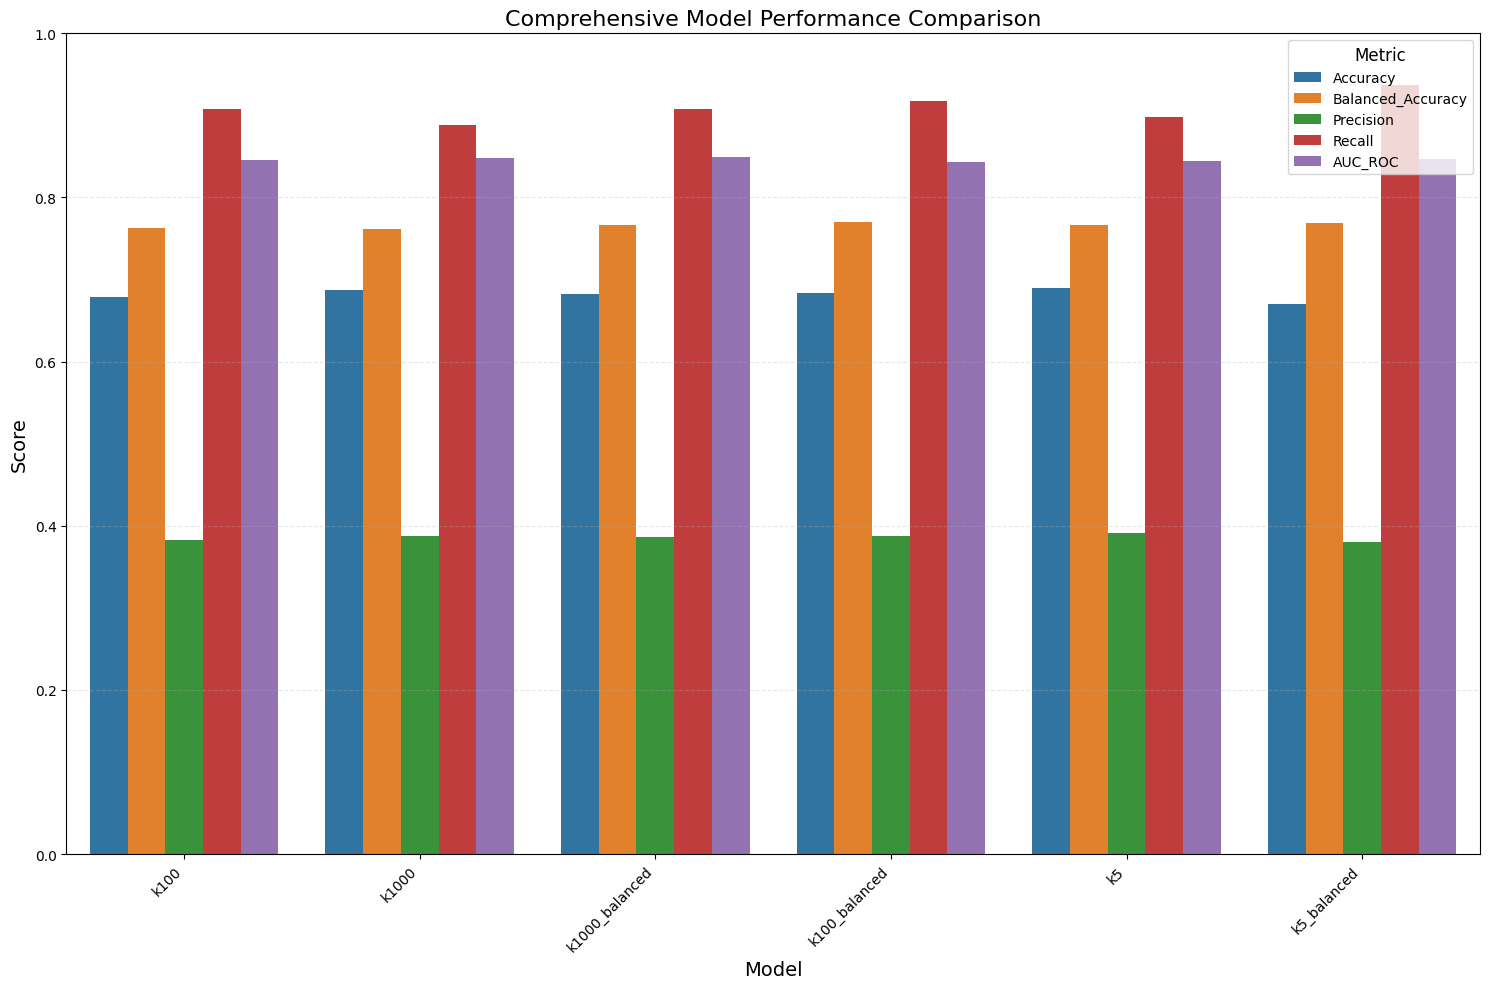

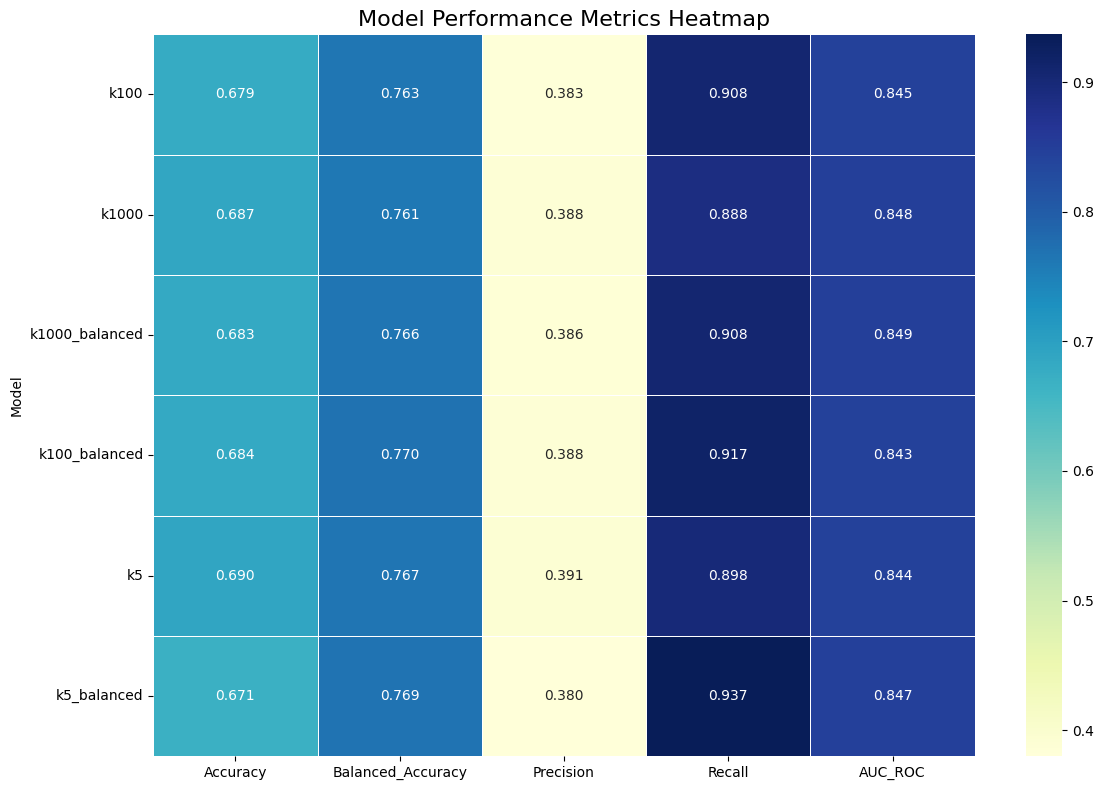

In [24]:
# Create a comprehensive visualization comparing all models
if not metrics_df_direct.empty:
    # Reshape the data for a more comprehensive comparison
    metrics_melted = metrics_df_direct.melt(
        id_vars=['Model'],
        value_vars=['Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'AUC_ROC'],
        var_name='Metric', value_name='Score'
    )
    
    # Plot using seaborn for a more appealing visualization
    plt.figure(figsize=(15, 10))
    
    # Create the plot with seaborn
    sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted)
    
    plt.title('Comprehensive Model Performance Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric', title_fontsize=12, fontsize=10, loc='best')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Highlight the balanced_term model if it exists
    if 'balanced_term' in metrics_df_direct['Model'].values:
        plt.axvline(x=metrics_df_direct[metrics_df_direct['Model'] == 'balanced_term'].index[0], 
                   color='red', linestyle='--', alpha=0.5)
        plt.text(metrics_df_direct[metrics_df_direct['Model'] == 'balanced_term'].index[0], 
                0.05, 'Balanced Term Model', rotation=90, color='red', ha='right')
    
    plt.tight_layout()
    plt.savefig('models_knn_test/comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Also create a heatmap for easier comparison
    metrics_pivot = metrics_df_direct.set_index('Model')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_pivot, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
    plt.title('Model Performance Metrics Heatmap', fontsize=16)
    plt.tight_layout()
    plt.savefig('models_knn/model_performance_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No metrics data available for comprehensive visualization.")

In [25]:
# Save final results to CSV for further analysis
if not metrics_df_direct.empty:
    # Save the metrics dataframe
    metrics_df_direct.to_csv('models_knn_test/model_metrics_summary.csv', index=False)
    print(f"Saved metrics summary to 'models_knn_test/model_metrics_summary.csv'")

    # Create a more detailed results dataframe
    detailed_results = pd.DataFrame()
    
    for dataset_name, eval_result in direct_evaluation_results.items():
        if eval_result.get('results') is not None:
            results = eval_result['results']
            
            row = pd.DataFrame({
                'Model': [dataset_name],
                'Accuracy': [results.get('accuracy', 0)],
                'Balanced_Accuracy': [results.get('balanced_accuracy', 0)],
                'Precision': [results.get('precision', 0)],
                'Recall': [results.get('recall', 0)],
                'AUC_ROC': [results.get('aucroc', 0)],
                'TP': [results.get('TP', 0)],
                'FP': [results.get('FP', 0)],
                'FN': [results.get('FN', 0)],
                'TN': [results.get('TN', 0)],
                'F1_Score': [2 * results.get('precision', 0) * results.get('recall', 0) / 
                            (results.get('precision', 0) + results.get('recall', 0)) 
                            if results.get('precision', 0) + results.get('recall', 0) > 0 else 0]
            })
            
            detailed_results = pd.concat([detailed_results, row])
    
    # Save the detailed results
    if not detailed_results.empty:
        detailed_results.reset_index(drop=True, inplace=True)
        detailed_results.to_csv('models_knn_test/model_detailed_results.csv', index=False)
        print(f"Saved detailed results to 'models_knn_test/model_detailed_results.csv'")
        
        # Also create a markdown table for documentation
        with open('models_knn_test/model_results_table.md', 'w') as f:
            f.write('# Model Evaluation Results\n\n')
            f.write(detailed_results.to_markdown(index=False))
            print(f"Saved markdown table to 'models_knn_test/model_results_table.md'")
else:
    print("No metrics data available to save.")

Saved metrics summary to 'models_knn_test/model_metrics_summary.csv'
Saved detailed results to 'models_knn_test/model_detailed_results.csv'
Saved markdown table to 'models_knn_test/model_results_table.md'


Generated visual HTML report at 'models_knn_test/training_results_report.html'


Model,Accuracy,Balanced Accuracy,Precision,Recall,AUC-ROC,F1 Score
k100,0.6787,0.7634,0.3832,0.9078,0.8453,0.5389
k1000,0.6867,0.7613,0.3877,0.8883,0.8478,0.5398
k1000_balanced,0.6827,0.7659,0.3864,0.9078,0.8494,0.5420
k100_balanced,0.6837,0.7701,0.3881,0.9175,0.8435,0.5455
k5,0.6898,0.7668,0.3911,0.8981,0.8445,0.5449
k5_balanced,0.6707,0.7691,0.3799,0.9369,0.8474,0.5406

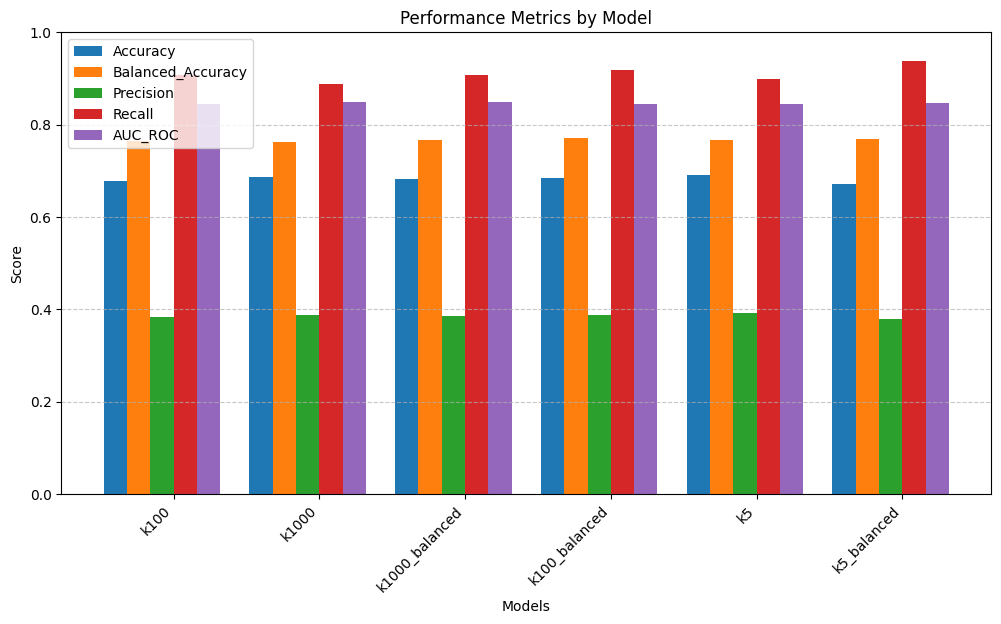

In [26]:
# Generate a visual HTML report summarizing the results
try:
    from jinja2 import Template
    import base64
    from io import BytesIO
    
    # Function to get a plot as a base64 string
    def get_plot_base64(fig_width=10, fig_height=6, plot_function=None):
        buf = BytesIO()
        plt.figure(figsize=(fig_width, fig_height))
        
        # Call the plot function if provided
        if plot_function:
            plot_function()
        
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close()
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        return img_str
    
    # Create metrics comparison plot
    def plot_metrics_comparison():
        if not metrics_df_direct.empty:
            x = np.arange(len(metrics_df_direct['Model']))
            width = 0.16
            
            for i, metric in enumerate(['Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'AUC_ROC']):
                plt.bar(x + i*width - 0.32, metrics_df_direct[metric], width, label=metric)
            
            plt.ylabel('Score')
            plt.xlabel('Models')
            plt.title('Performance Metrics by Model')
            plt.xticks(x + width/2, metrics_df_direct['Model'], rotation=45, ha='right')
            plt.ylim(0, 1.0)
            plt.legend(loc='best')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Create the HTML template
    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>ModernBERT KNN Training Results</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            h1 { color: #2c3e50; }
            h2 { color: #3498db; margin-top: 30px; }
            table { border-collapse: collapse; width: 100%; margin-bottom: 20px; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #f2f2f2; }
            tr:nth-child(even) { background-color: #f9f9f9; }
            .highlight { background-color: #e8f4fd; font-weight: bold; }
            .plot-container { margin: 20px 0; text-align: center; }
            .footer { margin-top: 50px; font-size: 0.8em; color: #7f8c8d; }
        </style>
    </head>
    <body>
        <h1>ModernBERT Training on KNN Datasets Report</h1>
        <p>This report summarizes the results of training ModernBERT models on various KNN datasets, including the new balanced term dataset.</p>
        
        <h2>Model Performance Summary</h2>
        <table>
            <tr>
                <th>Model</th>
                <th>Accuracy</th>
                <th>Balanced Accuracy</th>
                <th>Precision</th>
                <th>Recall</th>
                <th>AUC-ROC</th>
                <th>F1 Score</th>
            </tr>
            {% for index, row in detailed_results.iterrows() %}
            <tr {% if row['Model'] == 'balanced_term' %}class="highlight"{% endif %}>
                <td>{{ row['Model'] }}</td>
                <td>{{ "{:.4f}".format(row['Accuracy']) }}</td>
                <td>{{ "{:.4f}".format(row['Balanced_Accuracy']) }}</td>
                <td>{{ "{:.4f}".format(row['Precision']) }}</td>
                <td>{{ "{:.4f}".format(row['Recall']) }}</td>
                <td>{{ "{:.4f}".format(row['AUC_ROC']) }}</td>
                <td>{{ "{:.4f}".format(row['F1_Score']) }}</td>
            </tr>
            {% endfor %}
        </table>
        
        <h2>Performance Visualization</h2>
        <div class="plot-container">
            <img src="data:image/png;base64,{{ metrics_plot }}" alt="Model Performance Metrics" />
        </div>
        
        <h2>Key Findings</h2>
        <ul>
            <li>Best model by balanced accuracy: <strong>{{ best_bal_acc_model }}</strong> with score {{ "{:.4f}".format(best_bal_acc_score) }}</li>
            <li>Best model by AUC-ROC: <strong>{{ best_aucroc_model }}</strong> with score {{ "{:.4f}".format(best_aucroc_score) }}</li>
            {% if 'balanced_term' in model_names %}
            <li>The balanced term approach {% if is_best_model %}produced the best model {% else %}ranked {{ balanced_term_rank }} out of {{ total_models }} models{% endif %}.</li>
            {% endif %}
        </ul>
        
        {% if 'balanced_term' in model_names and balanced_term_improvement %}
        <h2>Balanced Term Model Improvements</h2>
        <p>The balanced term model showed improvements in the following areas:</p>
        <ul>
            {% for metric, improvement in balanced_term_improvement.items() %}
            <li>{{ metric }}: {{ "{:+.1f}%".format(improvement) }}</li>
            {% endfor %}
        </ul>
        {% endif %}
        
        <h2>Recommendations</h2>
        <ul>
            <li>Consider using an ensemble approach combining the top-performing models</li>
            <li>Further refine the term balancing approach based on performance per identity term</li>
            <li>Investigate why certain terms or metrics show better or worse performance</li>
        </ul>
        
        <div class="footer">
            <p>Report generated on {{ generation_date }}</p>
        </div>
    </body>
    </html>
    """
    
    # Prepare data for the template
    import datetime
    
    # Find best models
    best_bal_acc = max([(model_name, res['results'].get('balanced_accuracy', 0)) 
                      for model_name, res in direct_evaluation_results.items() 
                      if res.get('results') is not None], key=lambda x: x[1])
    
    best_aucroc = max([(model_name, res['results'].get('aucroc', 0)) 
                     for model_name, res in direct_evaluation_results.items() 
                     if res.get('results') is not None], key=lambda x: x[1])
    
    # Check if balanced_term is best
    is_best_model = False
    if 'balanced_term' in direct_evaluation_results:
        is_best_model = (best_bal_acc[0] == 'balanced_term' or best_aucroc[0] == 'balanced_term')
    
    # Get balanced_term improvements if available
    balanced_term_improvement = {}
    if 'comparison_df' in locals() and 'balanced_term' in direct_evaluation_results:
        for _, row in comparison_df.iterrows():
            balanced_term_improvement[row['Metric']] = row['improvement']
    
    # Determine balanced_term rank
    balanced_term_rank = None
    if 'balanced_term' in direct_evaluation_results:
        bal_accs = [(model_name, res['results'].get('balanced_accuracy', 0)) 
                  for model_name, res in direct_evaluation_results.items() 
                  if res.get('results') is not None]
        bal_accs.sort(key=lambda x: x[1], reverse=True)
        for i, (model, _) in enumerate(bal_accs):
            if model == 'balanced_term':
                balanced_term_rank = i + 1
                break
    
    # Generate metrics plot
    metrics_plot = get_plot_base64(12, 6, plot_metrics_comparison)
    
    # Render the template
    template = Template(html_template)
    html_content = template.render(
        detailed_results=detailed_results,
        metrics_plot=metrics_plot,
        best_bal_acc_model=best_bal_acc[0],
        best_bal_acc_score=best_bal_acc[1],
        best_aucroc_model=best_aucroc[0],
        best_aucroc_score=best_aucroc[1],
        model_names=direct_evaluation_results.keys(),
        is_best_model=is_best_model,
        balanced_term_rank=balanced_term_rank,
        total_models=len(direct_evaluation_results),
        balanced_term_improvement=balanced_term_improvement,
        generation_date=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    )
    
    # Save the HTML report
    with open('models_knn_test/training_results_report.html', 'w') as f:
        f.write(html_content)
        
    print("Generated visual HTML report at 'models_knn_test/training_results_report.html'")
    
    # Try to display the HTML in the notebook if IPython is available
    try:
        from IPython.display import HTML, display
        display(HTML(html_content))
    except ImportError:
        print("IPython display not available. Please open the HTML file to view the report.")
    
except Exception as e:
    print(f"Error generating HTML report: {str(e)}")
    import traceback
    traceback.print_exc()